In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Acknowledgment:
# This work builds upon the JacobiConv implementation developed by the GraphPKU team.
# For reference, see: https://github.com/GraphPKU/JacobiConv
# We extend our sincere gratitude to the authors for their valuable contributions.


In [ ]:
!pip install numpy scikit-learn
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn.inits import glorot, zeros
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve, auc
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Di

In [ ]:
# cn_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_CN_dataset/Processed_histogram_features_CN/Histogram_feature_CN_FA_20bin.npy"
# mci_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_MCI_dataset/Processed_histogram_features_MCI/Histogram_feature_MCI_FA_20bin.npy"
cn_fa_feature_path = "/home/snu/Downloads/Histogram_feature_CN_FA_20bin.npy"
mci_fa_feature_path = "/home/snu/Downloads/Histogram_feature_MCI_FA_20bin.npy"
cn_features_dict = np.load(cn_fa_feature_path, allow_pickle=True).item()
cn_features = np.array(list(cn_features_dict.values()))

mci_features_dict = np.load(mci_fa_feature_path, allow_pickle=True).item()
mci_features = np.array(list(mci_features_dict.values()))

In [ ]:
cn_labels = np.zeros(cn_features.shape[0])
mci_labels = np.ones(mci_features.shape[0])

X = np.vstack((cn_features, mci_features))
y = np.hstack((cn_labels, mci_labels))

np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]
scaler = StandardScaler()
X = scaler.fit_transform(X)

num_nodes = X.shape[0]
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [ ]:
alpha = 0.1
X_norm = F.normalize(X_tensor, p=2, dim=1)
sim_matrix = torch.mm(X_norm, X_norm.T)
src, dst = torch.where(sim_matrix > alpha)
mask = src != dst
src, dst = src[mask], dst[mask]

edge_index = torch.stack([src, dst], dim=0).to(device)

X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

print(f"Graph Nodes: {num_nodes}, Edges: {edge_index.size(1)}, Device: {device}")

Graph Nodes: 300, Edges: 16208, Device: cuda


In [ ]:
num_nodes = X.shape[0]
adj_dense = torch.zeros((num_nodes, num_nodes), device=device)
adj_dense[edge_index[0], edge_index[1]] = 1.0
adj_dense.fill_diagonal_(1.0)

tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 1., 0., 1.]], device='cuda:0')

In [ ]:
class JacobiConv(MessagePassing):
    def __init__(self, in_channels, out_channels, K=3, alpha=1.0, beta=1.0,
                 normalization='sym', bias=True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(JacobiConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.normalization = normalization

        self.weight = nn.Parameter(torch.Tensor(K + 1, in_channels, out_channels))

        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        zeros(self.bias)

    def __norm__(self, edge_index, num_nodes, edge_weight=None, improved=False,
                 dtype=None):
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        fill_value = 2. if improved else 1.
        edge_index, edge_weight = add_self_loops(
            edge_index, edge_weight, fill_value, num_nodes)

        row, col = edge_index
        deg = degree(col, num_nodes, dtype=edge_weight.dtype)

        if self.normalization == 'sym':
            deg_inv_sqrt = deg.pow(-0.5)
            deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
            return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        elif self.normalization == 'rw':
            deg_inv = deg.pow(-1.0)
            deg_inv[deg_inv == float('inf')] = 0
            return edge_index, deg_inv[row] * edge_weight
        else:
            return edge_index, edge_weight

    def compute_jacobi_coeffs(self, k):
        if k == 0:
            return 1.0, 0.0, 0.0
        elif k == 1:
            theta_k = (self.alpha + self.beta + 2) / 2
            theta_k_prime = (self.alpha - self.beta) / 2
            return theta_k, theta_k_prime, 0.0
        else:
            theta_k = (2 * k + self.alpha + self.beta) * (2 * k + self.alpha + self.beta - 1) / (2 * k * (k + self.alpha + self.beta))
            theta_k_prime = (2 * k + self.alpha + self.beta - 1) * (self.alpha ** 2 - self.beta ** 2) / (2 * k * (k + self.alpha + self.beta) * (2 * k + self.alpha + self.beta - 2))
            theta_k_double = (k + self.alpha - 1) * (k + self.beta - 1) * (2 * k + self.alpha + self.beta) / (k * (k + self.alpha + self.beta) * (2 * k + self.alpha + self.beta - 2))
            return theta_k, theta_k_prime, theta_k_double

    def forward(self, x, edge_index, edge_weight=None):
        edge_index, norm = self.__norm__(edge_index, x.size(0), edge_weight,
                                         dtype=x.dtype)

        Tx_0 = x
        #out = torch.einsum('ijk,jk->ik', self.weight[0:1], Tx_0.unsqueeze(0))
        out = Tx_0 @ self.weight[0]


        if self.K > 0:
            Tx_1 = (self.alpha - self.beta) / 2 * x + (self.alpha + self.beta + 2) / 2 * self.propagate(edge_index, x=x, norm=norm)
            #out += torch.einsum('ijk,jk->ik', self.weight[1:2], Tx_1.unsqueeze(0))
            out += Tx_1 @ self.weight[1]

        for k in range(2, self.K + 1):
            theta_k, theta_k_prime, theta_k_double = self.compute_jacobi_coeffs(k)
            Tx_2 = theta_k * self.propagate(edge_index, x=Tx_1, norm=norm) + theta_k_prime * Tx_1 - theta_k_double * Tx_0
            #out += torch.einsum('ijk,jk->ik', self.weight[k:k+1], Tx_2.unsqueeze(0))
            out += Tx_2 @ self.weight[k]
            Tx_0, Tx_1 = Tx_1, Tx_2

        if self.bias is not None:
            out += self.bias

        return out

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def __repr__(self):
        return f'{self.__class__.__name__}({self.in_channels}, {self.out_channels}, K={self.K}, alpha={self.alpha}, beta={self.beta})'

In [ ]:
class JacobiNet(nn.Module):
    """
    Multi-layer JacobiConv network for node classification

    Args:
        in_channels (int): Size of input features
        hidden_channels (int): Size of hidden representations
        out_channels (int): Number of output classes
        num_layers (int): Number of JacobiConv layers (default: 2)
        K (int): Polynomial order for each layer (default: 3)
        alpha (float): Jacobi polynomial parameter alpha (default: 1.0)
        beta (float): Jacobi polynomial parameter beta (default: 1.0)
        dropout (float): Dropout probability (default: 0.5)
    """

    def __init__(self, in_channels, hidden_channels, out_channels,
                 num_layers=2, K=3, alpha=1.0, beta=1.0, dropout=0.2):
        super(JacobiNet, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout

        self.convs = nn.ModuleList()

        # First layer
        if num_layers == 1:
            self.convs.append(JacobiConv(in_channels, out_channels, K, alpha, beta))
        else:
            self.convs.append(JacobiConv(in_channels, hidden_channels, K, alpha, beta))

            # Hidden layers
            for _ in range(num_layers - 2):
                self.convs.append(JacobiConv(hidden_channels, hidden_channels, K, alpha, beta))

            # Output layer
            self.convs.append(JacobiConv(hidden_channels, out_channels, K, alpha, beta))

    def forward(self, x, edge_index, edge_weight=None):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_weight)
            if i < self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

In [ ]:
def modularity_loss(A, S):
    C = F.softmax(S, dim=1)
    d = torch.sum(A, dim=1)
    m = torch.sum(A)
    B = A - torch.outer(d, d) / (2 * m)
    return (-1 / (2 * m)) * torch.trace(torch.mm(torch.mm(C.t(), B), C))

def cut_loss(A, S):
    C = F.softmax(S, dim=1)
    A_pool = torch.matmul(torch.matmul(A, C).t(), C)
    D = torch.diag(torch.sum(A, dim=-1))
    D_pool = torch.matmul(torch.matmul(D, C).t(), C)
    return -(torch.trace(A_pool) / torch.trace(D_pool))

In [ ]:
cut = 0
lambda_unsup = 0.09
num_epochs = 5000
# device = X.device

In [ ]:
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)
num_epochs = 5000

accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []
all_fpr, all_tpr, all_y_true, all_y_proba = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
    test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

    model = JacobiNet(in_channels=X.shape[1], hidden_channels=512, out_channels=2,
                      num_layers=2, K=2, alpha=1.0, beta=1.0, dropout=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    ce_loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_tensor, edge_index)

        sup_loss = ce_loss_fn(out[train_mask], y_tensor[train_mask])

        # Subset adjacency and output for unsupervised loss
        # adj_train = adj_dense[train_mask][:, train_mask]
        # out_train = out[train_mask]

        unsup_loss = cut_loss(adj_dense, out) if cut else modularity_loss(adj_dense, out)

        total_loss = sup_loss + lambda_unsup * unsup_loss

        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"NaN/Inf loss at epoch {epoch}")
            break

        total_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Sup {sup_loss.item():.4f}, Unsup {unsup_loss.item():.4f}, Total {total_loss.item():.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor, edge_index)
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()

    y_true_test = y_tensor[test_mask].cpu().numpy()
    y_pred_test = y_pred[test_mask.cpu().numpy()]
    y_proba_test = y_pred_proba[test_mask.cpu().numpy()][:, 1]

    acc = accuracy_score(y_true_test, y_pred_test)
    prec = precision_score(y_true_test, y_pred_test)
    rec = recall_score(y_true_test, y_pred_test)
    f1 = f1_score(y_true_test, y_pred_test)
    loss_val = log_loss(y_true_test, y_pred_proba[test_mask.cpu().numpy()])

    fpr, tpr, _ = roc_curve(y_true_test, y_proba_test)
    auc_val = auc(fpr, tpr)


    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    losses.append(loss_val)
    all_auc.append(auc_val)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_y_true.extend(y_true_test)
    all_y_proba.extend(y_proba_test)

    print(f"Fold {fold+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | Loss: {loss_val:.4f} | AUC: {auc_val:.4f}")

print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")


Training fold 1
Epoch 0: Sup 1.8242, Unsup -0.2042, Total 1.8058
Epoch 500: Sup 0.0010, Unsup -0.2443, Total -0.0210
Epoch 1000: Sup 0.0004, Unsup -0.2521, Total -0.0223
Epoch 1500: Sup 0.0001, Unsup -0.2544, Total -0.0228
Epoch 2000: Sup 0.0001, Unsup -0.2563, Total -0.0229
Epoch 2500: Sup 0.0001, Unsup -0.2573, Total -0.0230
Epoch 3000: Sup 0.0001, Unsup -0.2580, Total -0.0231
Epoch 3500: Sup 0.0002, Unsup -0.2585, Total -0.0231
Epoch 4000: Sup 0.0002, Unsup -0.2586, Total -0.0231
Epoch 4500: Sup 0.0001, Unsup -0.2587, Total -0.0232
Fold 1 | Acc: 0.7667 | Prec: 0.7636 | Rec: 0.8400 | F1: 0.8000 | Loss: 1.4724 | AUC: 0.7899

Training fold 2
Epoch 0: Sup 3.6930, Unsup -0.2478, Total 3.6707
Epoch 500: Sup 0.0021, Unsup -0.2295, Total -0.0185
Epoch 1000: Sup 0.0011, Unsup -0.2408, Total -0.0206
Epoch 1500: Sup 0.0004, Unsup -0.2447, Total -0.0217
Epoch 2000: Sup 0.0004, Unsup -0.2468, Total -0.0218
Epoch 2500: Sup 0.0003, Unsup -0.2489, Total -0.0221
Epoch 3000: Sup 0.0002, Unsup -0.249

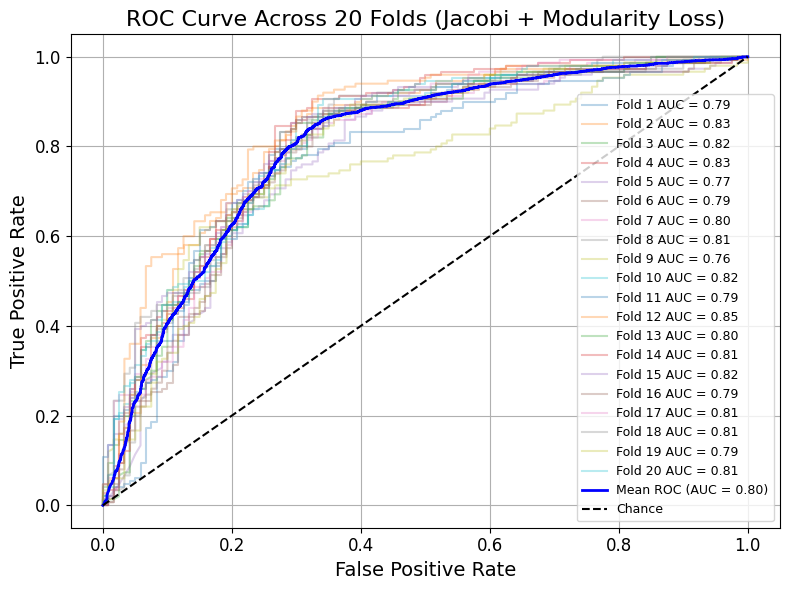

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (Jacobi + Modularity Loss)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()